<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimização do Modelo SARIMA</font></b></strong>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

No modelo 18 criamos um Modelo SARIMA aplicando Grid Search Stepwise para buscar os melhores valores dos hiperparâmetros.

Agora, vamos tentar melhorar a performance do modelo criado mudando a estratégia do Grid Search.  

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time
from datetime import datetime
from datetime import date, timedelta

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

sys        : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
numpy      : 1.21.5
scipy      : 1.9.1
sklearn    : 1.0.2
pandas     : 1.4.4
matplotlib : 3.5.2
statsmodels: 0.13.2



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
# Dados
dataframe.head()

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0


In [5]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Quantidade']

In [6]:
# Random seed 
np.random.seed(7)

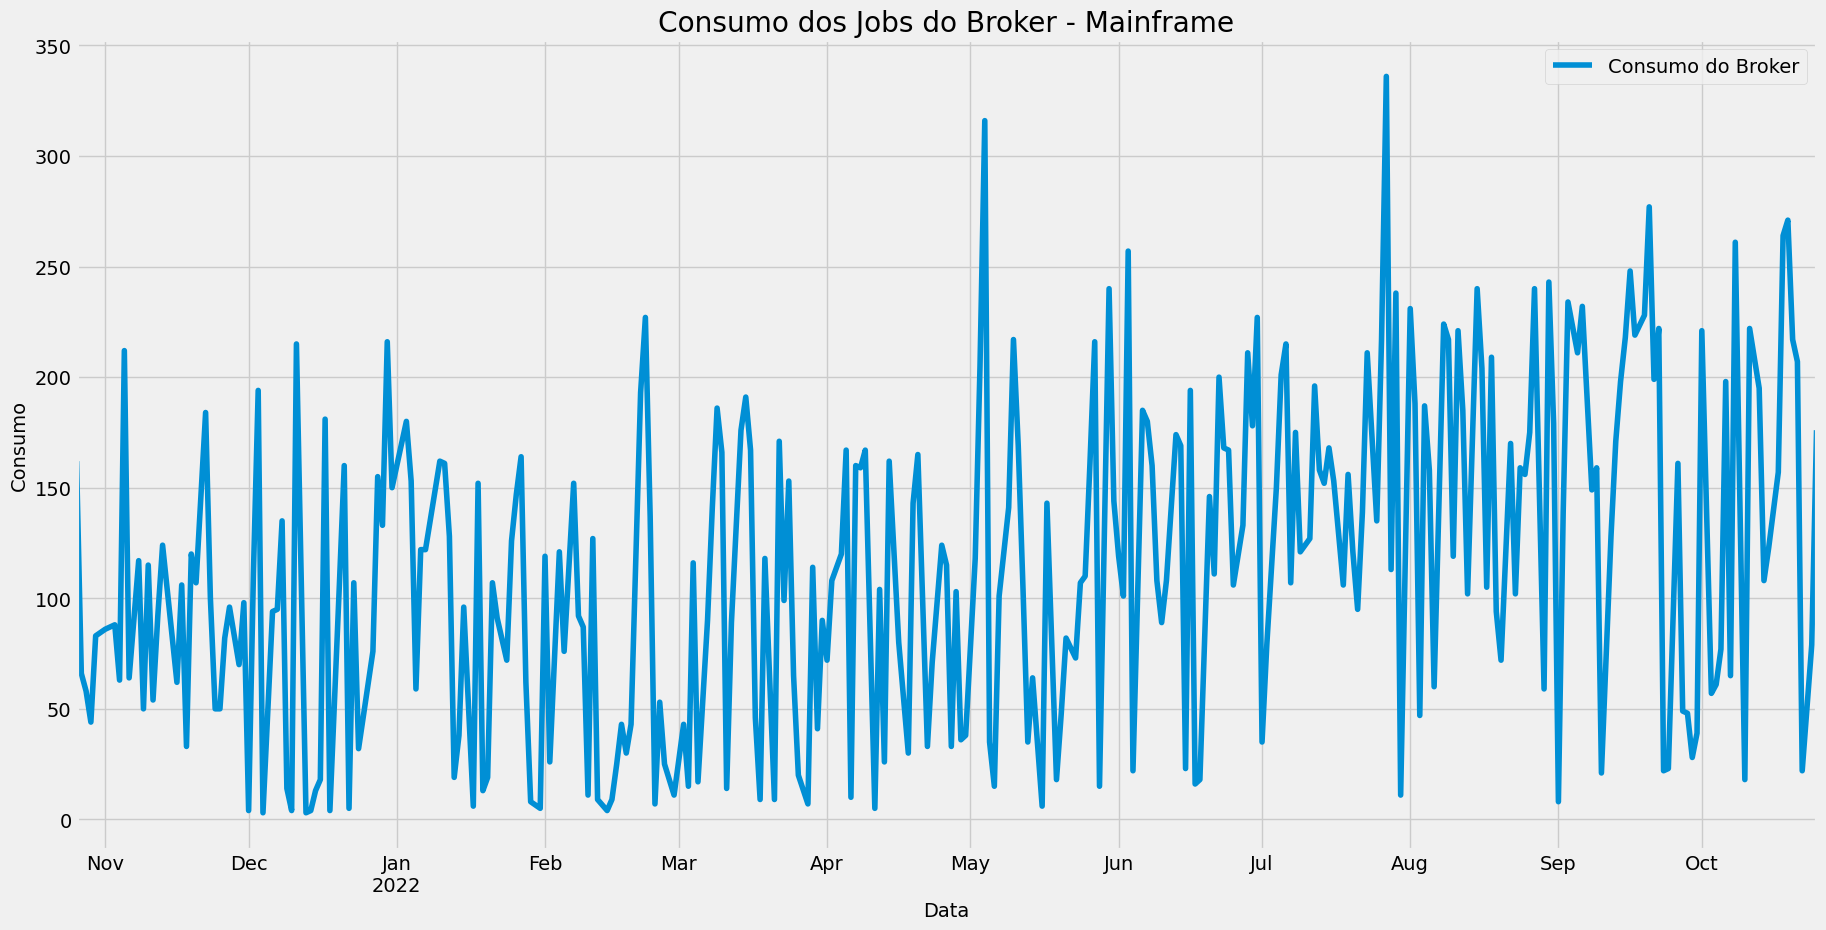

In [7]:
# Plot
target.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

273 92


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Otimização do Modelo SARIMA

### Grid Search Método 2 

Neste método de Grid Search, nós testamos diversas combinações dos hiperparâmetros do modelo SARIMA. Tome cuidado para não exagerar nas combinações. Valores de 0 e 1 resolvem a grande maioria dos problemas.

In [12]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 3)

Agora geramos diferentes combinações de p, d e q.

In [13]:
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [14]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 10),
 (0, 0, 1, 10),
 (0, 0, 2, 10),
 (0, 1, 0, 10),
 (0, 1, 1, 10),
 (0, 1, 2, 10),
 (0, 2, 0, 10),
 (0, 2, 1, 10),
 (0, 2, 2, 10),
 (1, 0, 0, 10),
 (1, 0, 1, 10),
 (1, 0, 2, 10),
 (1, 1, 0, 10),
 (1, 1, 1, 10),
 (1, 1, 2, 10),
 (1, 2, 0, 10),
 (1, 2, 1, 10),
 (1, 2, 2, 10),
 (2, 0, 0, 10),
 (2, 0, 1, 10),
 (2, 0, 2, 10),
 (2, 1, 0, 10),
 (2, 1, 1, 10),
 (2, 1, 2, 10),
 (2, 2, 0, 10),
 (2, 2, 1, 10),
 (2, 2, 2, 10)]

In [15]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 10)
SARIMAX: (0, 0, 1) x (0, 0, 2, 10)
SARIMAX: (0, 0, 2) x (0, 1, 0, 10)
SARIMAX: (0, 0, 2) x (0, 1, 1, 10)


In [16]:
# Grid Search
warnings.filterwarnings("ignore")

start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}10 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}10 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)


current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))


Hora de Início = 22:00:18
SARIMA(0, 0, 0)x(0, 0, 0, 10)10 - AIC:3364.823269653428
SARIMA(0, 0, 0)x(0, 0, 1, 10)10 - AIC:3149.3355541345927
SARIMA(0, 0, 0)x(0, 0, 2, 10)10 - AIC:2999.099969772331
SARIMA(0, 0, 0)x(0, 1, 0, 10)10 - AIC:3080.323054017613
SARIMA(0, 0, 0)x(0, 1, 1, 10)10 - AIC:2823.722703374893
SARIMA(0, 0, 0)x(0, 1, 2, 10)10 - AIC:2713.29139040184
SARIMA(0, 0, 0)x(0, 2, 0, 10)10 - AIC:3251.102071765027
SARIMA(0, 0, 0)x(0, 2, 1, 10)10 - AIC:2885.369104545175
SARIMA(0, 0, 0)x(0, 2, 2, 10)10 - AIC:2649.7284151043814
SARIMA(0, 0, 0)x(1, 0, 0, 10)10 - AIC:3060.1044140405143
SARIMA(0, 0, 0)x(1, 0, 1, 10)10 - AIC:2931.8873781922503
SARIMA(0, 0, 0)x(1, 0, 2, 10)10 - AIC:2824.93371060899
SARIMA(0, 0, 0)x(1, 1, 0, 10)10 - AIC:2900.6495314090994
SARIMA(0, 0, 0)x(1, 1, 1, 10)10 - AIC:2824.9764900503537
SARIMA(0, 0, 0)x(1, 1, 2, 10)10 - AIC:2715.1673277118252
SARIMA(0, 0, 0)x(1, 2, 0, 10)10 - AIC:2997.106605031606
SARIMA(0, 0, 0)x(1, 2, 1, 10)10 - AIC:2816.9935966767684
SARIMA(0, 0, 0)x

SARIMA(0, 1, 2)x(1, 0, 1, 10)10 - AIC:2855.2074761579897
SARIMA(0, 1, 2)x(1, 0, 2, 10)10 - AIC:2752.932969118429
SARIMA(0, 1, 2)x(1, 1, 0, 10)10 - AIC:2878.760472505156
SARIMA(0, 1, 2)x(1, 1, 1, 10)10 - AIC:2773.907083710156
SARIMA(0, 1, 2)x(1, 1, 2, 10)10 - AIC:2666.0210489800256
SARIMA(0, 1, 2)x(1, 2, 0, 10)10 - AIC:2973.0208979736353
SARIMA(0, 1, 2)x(1, 2, 1, 10)10 - AIC:2775.667147224419
SARIMA(0, 1, 2)x(1, 2, 2, 10)10 - AIC:2606.33612694738
SARIMA(0, 1, 2)x(2, 0, 0, 10)10 - AIC:2783.06034639278
SARIMA(0, 1, 2)x(2, 0, 1, 10)10 - AIC:2784.8849745465254
SARIMA(0, 1, 2)x(2, 0, 2, 10)10 - AIC:2754.9283145533964
SARIMA(0, 1, 2)x(2, 1, 0, 10)10 - AIC:2729.1502108146897
SARIMA(0, 1, 2)x(2, 1, 1, 10)10 - AIC:2699.2174180300112
SARIMA(0, 1, 2)x(2, 1, 2, 10)10 - AIC:2664.8744264594357
SARIMA(0, 1, 2)x(2, 2, 0, 10)10 - AIC:2767.5954494685675
SARIMA(0, 1, 2)x(2, 2, 1, 10)10 - AIC:2660.3116199747064
SARIMA(0, 1, 2)x(2, 2, 2, 10)10 - AIC:2608.013072254602
SARIMA(0, 2, 0)x(0, 0, 0, 10)10 - AIC:33

SARIMA(1, 0, 1)x(2, 1, 0, 10)10 - AIC:2721.3551637356004
SARIMA(1, 0, 1)x(2, 1, 1, 10)10 - AIC:2696.7451987182985
SARIMA(1, 0, 1)x(2, 1, 2, 10)10 - AIC:2684.780545669606
SARIMA(1, 0, 1)x(2, 2, 0, 10)10 - AIC:2761.484211641633
SARIMA(1, 0, 1)x(2, 2, 1, 10)10 - AIC:2652.110150101412
SARIMA(1, 0, 1)x(2, 2, 2, 10)10 - AIC:2628.5685618903008
SARIMA(1, 0, 2)x(0, 0, 0, 10)10 - AIC:2968.828902125865
SARIMA(1, 0, 2)x(0, 0, 1, 10)10 - AIC:2864.0470607378857
SARIMA(1, 0, 2)x(0, 0, 2, 10)10 - AIC:2763.81017926863
SARIMA(1, 0, 2)x(0, 1, 0, 10)10 - AIC:3040.965218213236
SARIMA(1, 0, 2)x(0, 1, 1, 10)10 - AIC:2784.367280798031
SARIMA(1, 0, 2)x(0, 1, 2, 10)10 - AIC:2676.3516613827787
SARIMA(1, 0, 2)x(0, 2, 0, 10)10 - AIC:3208.9291706763424
SARIMA(1, 0, 2)x(0, 2, 1, 10)10 - AIC:2844.967110142409
SARIMA(1, 0, 2)x(0, 2, 2, 10)10 - AIC:2614.255272194323
SARIMA(1, 0, 2)x(1, 0, 0, 10)10 - AIC:2889.557098639849
SARIMA(1, 0, 2)x(1, 0, 1, 10)10 - AIC:2866.445214161884
SARIMA(1, 0, 2)x(1, 0, 2, 10)10 - AIC:2764.

SARIMA(1, 2, 1)x(0, 1, 2, 10)10 - AIC:2740.605331953734
SARIMA(1, 2, 1)x(0, 2, 0, 10)10 - AIC:3275.1566295444127
SARIMA(1, 2, 1)x(0, 2, 1, 10)10 - AIC:2911.439952584804
SARIMA(1, 2, 1)x(0, 2, 2, 10)10 - AIC:2680.09338620554
SARIMA(1, 2, 1)x(1, 0, 0, 10)10 - AIC:2945.157506650624
SARIMA(1, 2, 1)x(1, 0, 1, 10)10 - AIC:2936.844988757043
SARIMA(1, 2, 1)x(1, 0, 2, 10)10 - AIC:2831.141279485097
SARIMA(1, 2, 1)x(1, 1, 0, 10)10 - AIC:2926.439581072106
SARIMA(1, 2, 1)x(1, 1, 1, 10)10 - AIC:2852.045352064383
SARIMA(1, 2, 1)x(1, 1, 2, 10)10 - AIC:2738.665827722527
SARIMA(1, 2, 1)x(1, 2, 0, 10)10 - AIC:3011.8162596548173
SARIMA(1, 2, 1)x(1, 2, 1, 10)10 - AIC:2842.4582600125395
SARIMA(1, 2, 1)x(1, 2, 2, 10)10 - AIC:2681.7966288722264
SARIMA(1, 2, 1)x(2, 0, 0, 10)10 - AIC:2839.8827902643798
SARIMA(1, 2, 1)x(2, 0, 1, 10)10 - AIC:2841.542179273129
SARIMA(1, 2, 1)x(2, 0, 2, 10)10 - AIC:2832.2970034208483
SARIMA(1, 2, 1)x(2, 1, 0, 10)10 - AIC:2781.705485127952
SARIMA(1, 2, 1)x(2, 1, 1, 10)10 - AIC:2752.

SARIMA(2, 1, 0)x(1, 2, 1, 10)10 - AIC:2832.7754077619993
SARIMA(2, 1, 0)x(1, 2, 2, 10)10 - AIC:2678.3858610613847
SARIMA(2, 1, 0)x(2, 0, 0, 10)10 - AIC:2815.0844165220046
SARIMA(2, 1, 0)x(2, 0, 1, 10)10 - AIC:2816.945226191795
SARIMA(2, 1, 0)x(2, 0, 2, 10)10 - AIC:2818.941596495595
SARIMA(2, 1, 0)x(2, 1, 0, 10)10 - AIC:2757.336095863723
SARIMA(2, 1, 0)x(2, 1, 1, 10)10 - AIC:2727.690356040984
SARIMA(2, 1, 0)x(2, 1, 2, 10)10 - AIC:2726.276187332911
SARIMA(2, 1, 0)x(2, 2, 0, 10)10 - AIC:2794.308915852469
SARIMA(2, 1, 0)x(2, 2, 1, 10)10 - AIC:2684.7823233609424
SARIMA(2, 1, 0)x(2, 2, 2, 10)10 - AIC:2669.1319399189174
SARIMA(2, 1, 1)x(0, 0, 0, 10)10 - AIC:2970.5978137119646
SARIMA(2, 1, 1)x(0, 0, 1, 10)10 - AIC:2865.683180721461
SARIMA(2, 1, 1)x(0, 0, 2, 10)10 - AIC:2764.7456494479575
SARIMA(2, 1, 1)x(0, 1, 0, 10)10 - AIC:3045.464916678603
SARIMA(2, 1, 1)x(0, 1, 1, 10)10 - AIC:2784.408945989183
SARIMA(2, 1, 1)x(0, 1, 2, 10)10 - AIC:2677.1796173855187
SARIMA(2, 1, 1)x(0, 2, 0, 10)10 - AIC:32

In [12]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(treino,
                                             order = (0, 1, 2),
                                             seasonal_order = (0, 2, 2, 10),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [13]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [19]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Quantidade   No. Observations:                  273
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 10)   Log Likelihood               -1297.681
Date:                            Wed, 21 Dec 2022   AIC                           2605.362
Time:                                    22:21:16   BIC                           2622.531
Sample:                                10-26-2021   HQIC                          2612.288
                                     - 07-25-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7313    250.809     -0.003      0.998    -492.309     490.846
ma.L2         -0.2687     67.376   

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a otimizaçã dos hiperparâmetros.

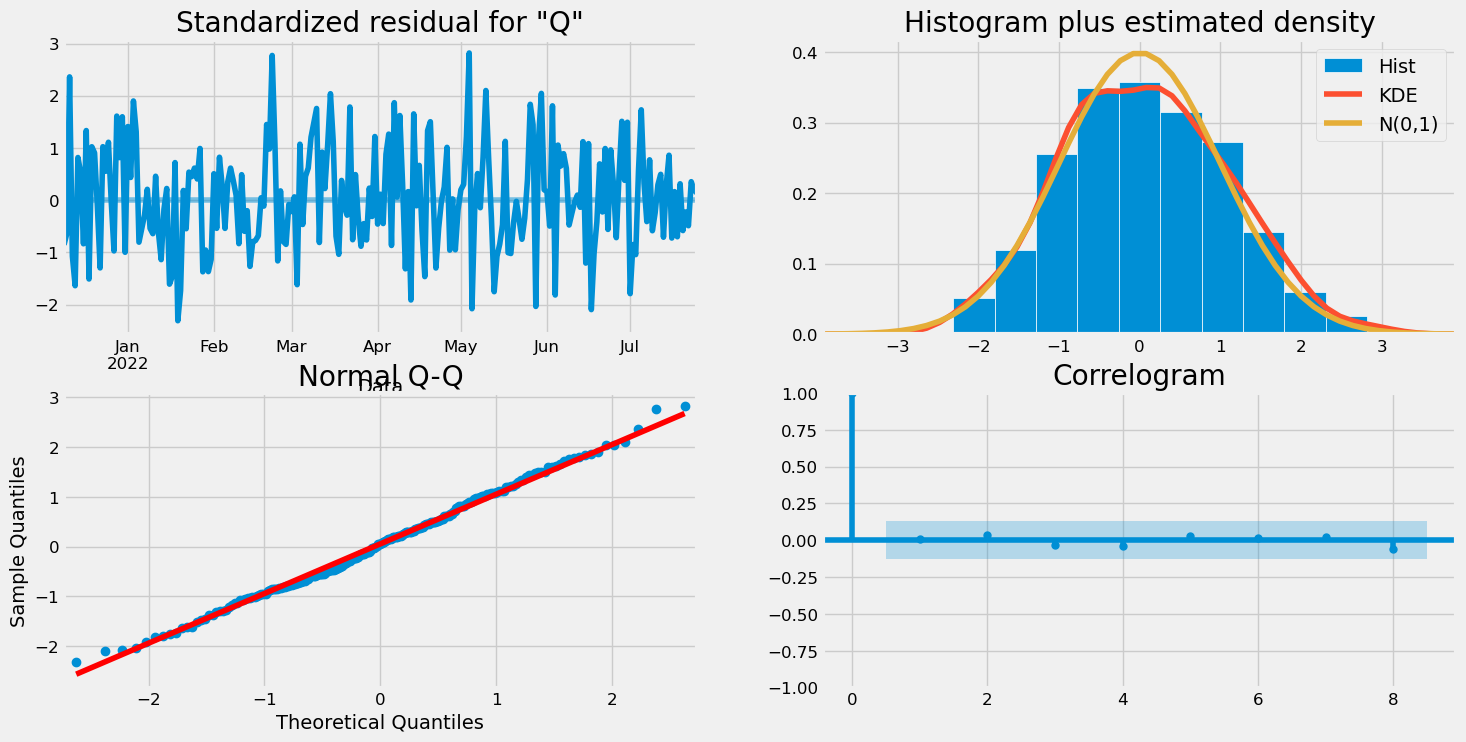

In [20]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

**Diagnóstico do Modelo:**

- Nossa principal preocupação é garantir que os resíduos do nosso modelo não sejam correlacionados e sejam normalmente distribuídos com média zero.

- Se o modelo SARIMA não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

O diagnóstico do modelo sugere que o resíduo do modelo é normalmente distribuído com base no seguinte:

- No gráfico superior direito, a linha azul do KDE segue de perto a linha N (0,1). Onde N (0,1) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. Essa é uma boa indicação de que os resíduos são normalmente distribuídos.

- O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras coletadas de uma distribuição normal padrão. Novamente, essa é uma forte indicação de que os resíduos são normalmente distribuídos.

- Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

- Isso é confirmado pelo gráfico de autocorrelação (isto é, correlograma) no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si.

In [19]:
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
print("inicio: ", inicio, " fim : ", fim, "n dias: ", td)

inicio:  2022-07-25 00:00:00  fim :  2022-10-25 00:00:00 n dias:  92 days, 0:00:00


In [20]:
# Previsões com o modelo
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = inicio, end = fim, dynamic = False)

In [21]:
# Intervalo de confiança
sarima_predict_conf_2 = sarima_predict_2.conf_int()

In [34]:
sarima_predict_conf_2

,lower Quantidade,upper Quantidade
2022-07-25,2.208373,250.581114
2022-07-26,65.975074,314.180080
2022-07-27,7.814409,266.031358
2022-07-28,18.565019,276.781992
2022-07-29,27.423280,285.640257
...,...,...
2022-10-21,154.565471,465.334898
2022-10-22,101.350603,412.533609
2022-10-23,48.146322,359.683982
2022-10-24,137.401339,456.888506


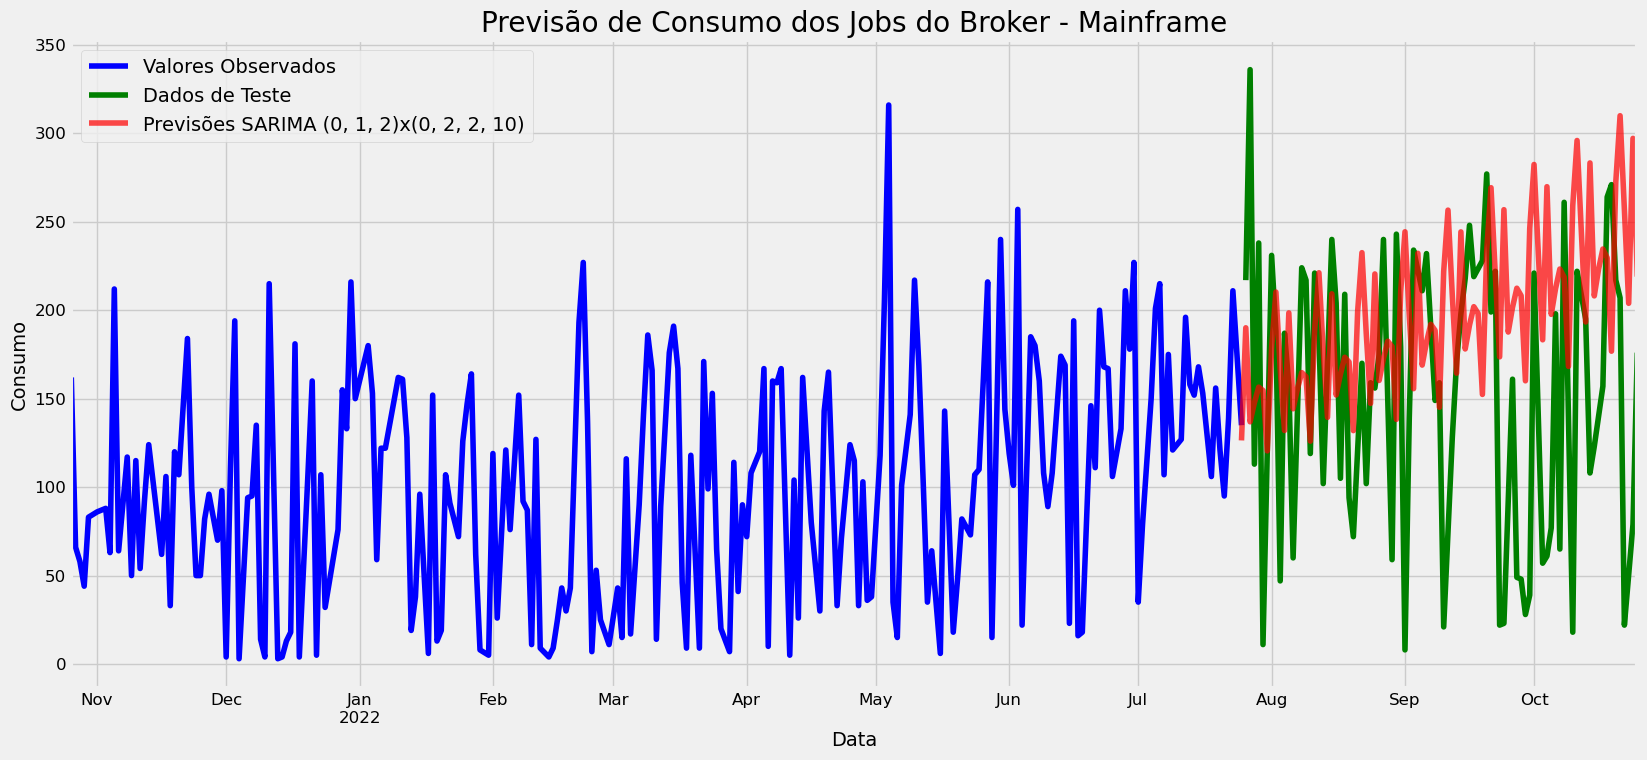

In [22]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 2)x(0, 2, 2, 10)' , 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
#ax.fill_between(sarima_predict_conf_2.index,
#                # lower sales
#                sarima_predict_conf_2.iloc[:, 0],
#                # upper sales
#                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo dos Jobs do Broker - Mainframe')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.legend()
plt.show()

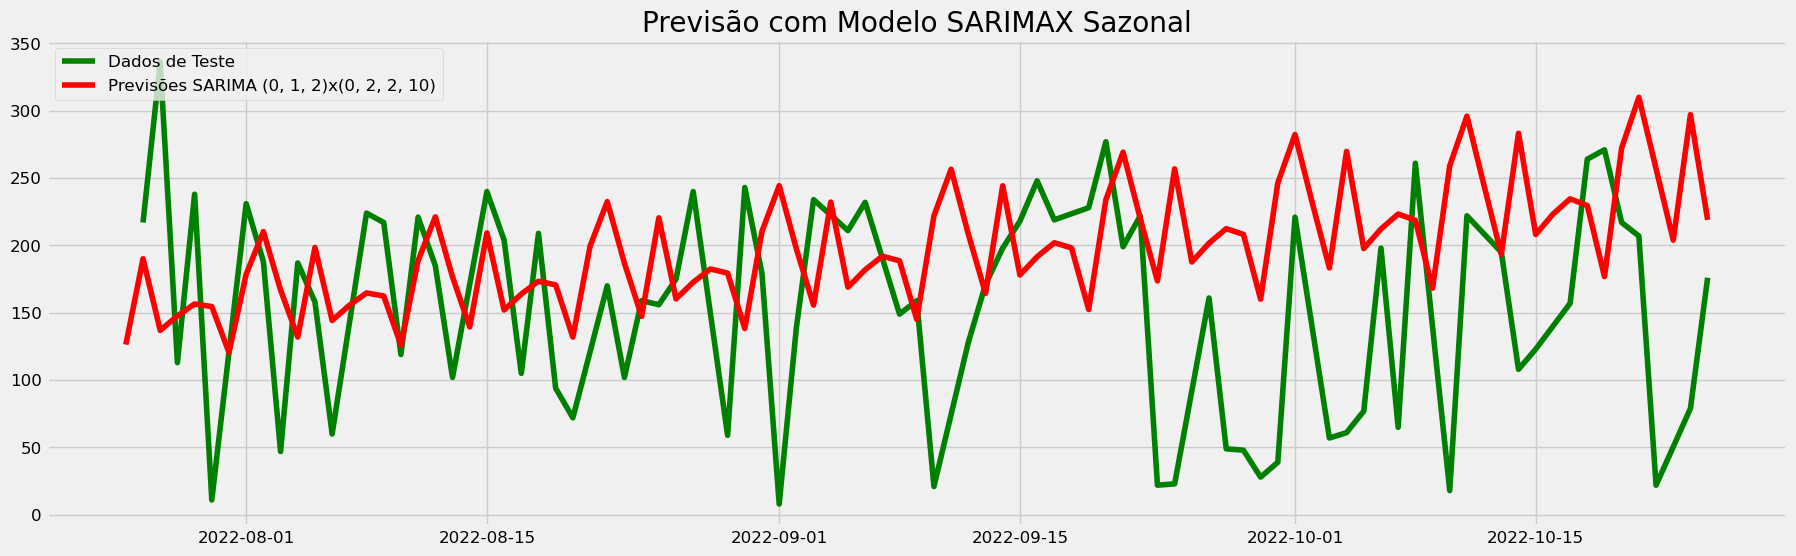

In [23]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(sarima_predict_2.predicted_mean, label = 'Previsões SARIMA (0, 1, 2)x(0, 2, 2, 10)', color = 'red')
plt.title('Previsão com Modelo SARIMAX Sazonal')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [24]:
# Calculando a performance
sarima_results = performance(treino, sarima_predict_2.predicted_mean)

MSE das previsões é 74.0504
RMSE das previsões é 8.6053
MAPE das previsões é 6.3743


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [52]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 130)

In [53]:
horizonte_60_predict_2.predicted_mean

2022-07-26    190.077577
2022-07-27    136.922883
2022-07-28    147.673505
2022-07-29    156.531768
2022-07-30    154.606979
                 ...    
2022-11-28    215.614952
2022-11-29    329.938642
2022-11-30    370.389715
2022-12-01    312.567189
2022-12-02    250.470095
Freq: D, Name: predicted_mean, Length: 130, dtype: float64

In [54]:
# Intervalo de confiança
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
#horizonte_60_predict_2_conf_2

In [55]:
horizonte_60_predict_2_conf_2

,lower Quantidade,upper Quantidade
2022-07-26,65.975074,314.180080
2022-07-27,7.814409,266.031358
2022-07-28,18.565019,276.781992
2022-07-29,27.423280,285.640257
2022-07-30,25.498490,283.715467
...,...,...
2022-11-28,37.720964,393.508940
2022-11-29,152.044149,507.833135
2022-11-30,192.493152,548.286279
2022-12-01,134.329698,490.804681


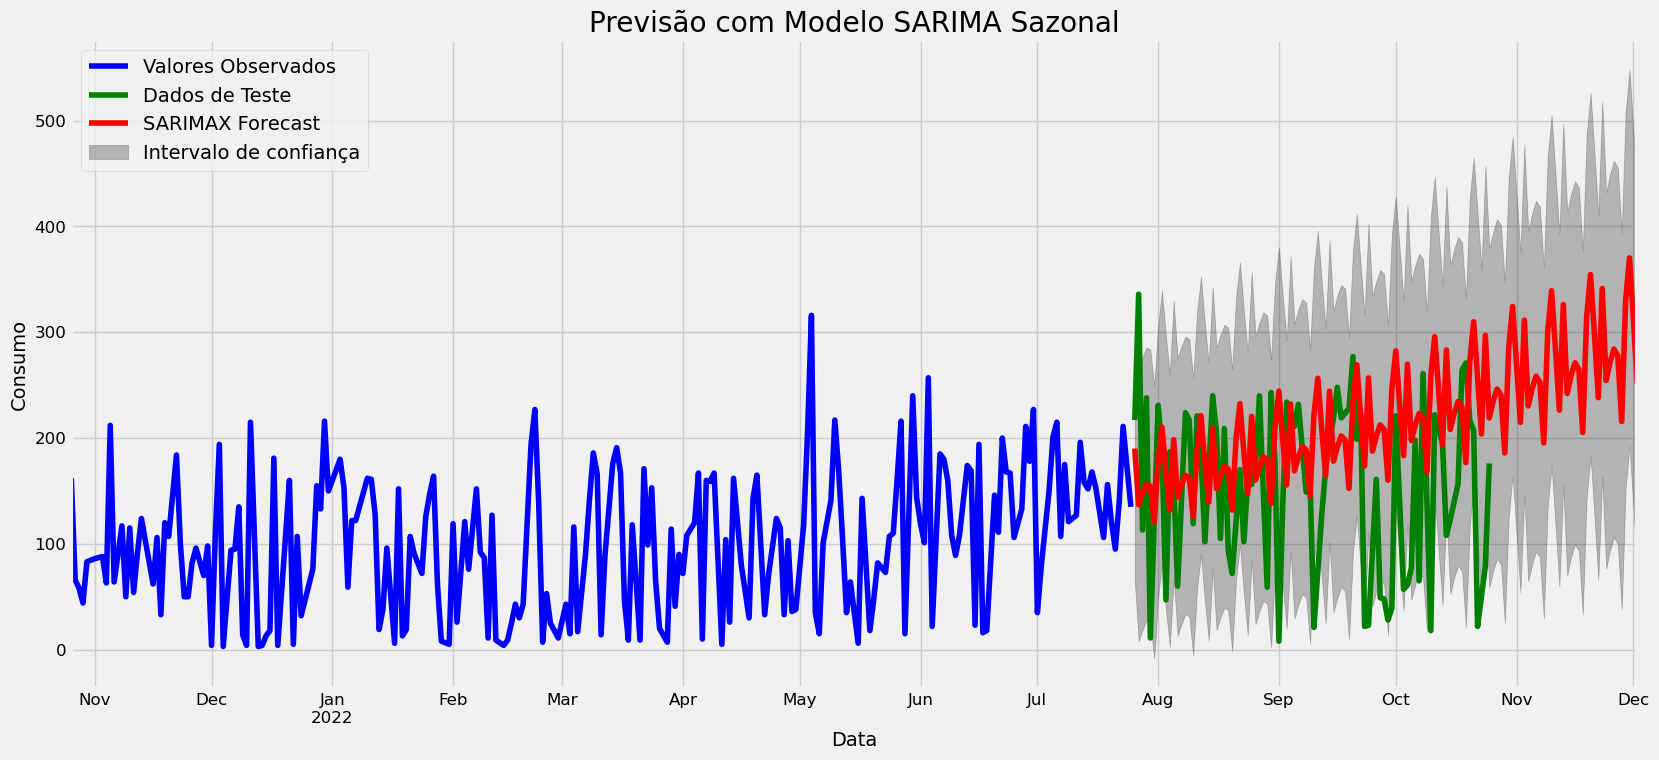

In [60]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMAX Forecast', color = 'red')

# Plot do intervalo de confiança
ax.fill_between(horizonte_60_predict_2_conf_2.index,
                horizonte_60_predict_2_conf_2.iloc[:, 0],
                horizonte_60_predict_2_conf_2.iloc[:, 1], label = 'Intervalo de confiança', color = 'k', alpha = .25)

# Plot
plt.title('Previsão com Modelo SARIMA Sazonal')
ax.set_xlabel('Data')
ax.set_ylabel('Consumo')
plt.legend(loc = 'upper left')
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [38]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.20772864]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

O modelo SARIMA (0, 1, 2)x(0, 2, 2, 10) fornece um bom ajuste e boa capacidade de previsão.

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim